In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from tqdm import tqdm
import tensorflow as tf

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report 
from sklearn.metrics import roc_curve, auc

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'sample_submission.csv', 'train']


In [28]:
img_width = 50
img_height = 50
TRAIN_DIR = '../input/train/'

In [29]:
def load_img():
    x = []
    y = []
    i=1
    for img in tqdm(os.listdir(TRAIN_DIR)):
        if 'dog' in img:
            y.append(1)
        elif 'cat' in img:
            y.append(0)
            
        path = os.path.join(TRAIN_DIR, img)
        img = cv2.imread(path)
        img = cv2.resize(img , (img_width,img_height))
        x.append(np.array(img))
        i = i+1
        if i >24500:
            break
            
    return x, y

In [30]:
x, y = load_img()


 25%|██▌       | 6258/25001 [00:14<00:43, 433.54it/s]


 51%|█████     | 12633/25001 [00:29<00:27, 448.64it/s]


 77%|███████▋  | 19236/25001 [00:43<00:12, 457.67it/s]


 98%|█████████▊| 24492/25001 [00:55<00:01, 479.85it/s]

In [31]:
x = np.array(x)

In [32]:
def error_rate(p, t):
    return np.mean(p != t)
def standardize(x):
    return (x/255)

In [33]:
#split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)
del x
del y
x_train = standardize(x_train)
x_test = standardize(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [34]:
def convolution(x, w, b, pad):
    conv_out = tf.nn.conv2d(x, w, strides=[1,1,1,1], padding=pad)
    conv_out = tf.nn.bias_add(conv_out, b)
    return conv_out
def pooling(conv_out):
    pool_out = tf.nn.max_pool(conv_out, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
    return tf.nn.relu(pool_out)

In [35]:
def init_filter(shape, poolsz):
    # w = np.random.randn(*shape) * np.sqrt(2) / np.sqrt(np.prod(shape[:-1]) + shape[-1]*np.prod(shape[:-2]) / np.prod(poolsz))
    w = np.random.randn(*shape) * np.sqrt(2.0 / np.prod(shape[:-1]))
    #w = np.random.randn(*shape)
    return w.astype(np.float32)

In [36]:
#hyperparameters
max_iter = 50
lr=0.01
N=x_train.shape[0]
K=1
H1=100
poolsz = (2,2)

In [37]:
#bias and weights
#Convolution
w1_shape = (5,5,3,20)
w1_init = init_filter(w1_shape, poolsz)
b1_init = np.zeros(w1_shape[-1], dtype = np.float32)

w2_shape = (3,3,20,50)
w2_init = init_filter(w2_shape, poolsz)
b2_init = np.zeros(w2_shape[-1], dtype = np.float32)

w3_shape = (13,13,50,100)
w3_init = init_filter(w3_shape, poolsz)
b3_init = np.zeros(w3_shape[-1], dtype = np.float32)

w4_shape = (7,7,100,K)
w4_init = init_filter(w4_shape, poolsz)
b4_init = np.zeros(w4_shape[-1], dtype = np.float32)

In [38]:
#tf variables and place holders
x = tf.placeholder(tf.float32, shape=(None,50,50,3), name='x')
t = tf.placeholder(tf.float32, shape=(None, K), name = 't')
w1 = tf.Variable(w1_init.astype(np.float32))
b1 = tf.Variable(b1_init.astype(np.float32))
w2 = tf.Variable(w2_init.astype(np.float32))
b2 = tf.Variable(b2_init.astype(np.float32))
w3 = tf.Variable(w3_init.astype(np.float32))
b3 = tf.Variable(b3_init.astype(np.float32))
w4 = tf.Variable(w4_init.astype(np.float32))
b4 = tf.Variable(b4_init.astype(np.float32))

In [39]:
x_train.shape

(17150, 50, 50, 3)

In [40]:
#define model
c_out1 = convolution(x, w1, b1, "SAME")
z1 = pooling(c_out1)

c_out2 = convolution(z1, w2, b2, "SAME")
z2 = pooling(c_out2)

c_out3 = convolution(z2, w3, b3, "SAME")
z3 = pooling(c_out3)

c_out4 = convolution(z3, w4, b4, "VALID")

calcY = tf.reshape(c_out4,[-1,K])
#cost
cost = tf.reduce_sum(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=calcY,
            labels=t
        )
    )
#optimizer - adam
train_op = tf.train.AdamOptimizer(0.001).minimize(cost)
#optimizer - RMS Prop
#train_op = tf.train.RMSPropOptimizer(0.01, decay=0.99, momentum=0.9).minimize(cost)
#softmax - predict probability for each class
predictor_y_prob = tf.nn.sigmoid(calcY)
#y predicted
predictor_y = tf.round(predictor_y_prob)

In [41]:
#arrays
test_costs = []
train_costs = []

In [42]:
y_train.shape

(17150, 1)

In [43]:
batch_sz = 50
#initializing session
init = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(init)
    
    for i in range(50):
        for j in range(500):
            Xbatch = x_train[j*batch_sz:(j*batch_sz + batch_sz),]
            Ybatch = y_train[j*batch_sz:(j*batch_sz + batch_sz),]
            if len(Xbatch) == batch_sz:
                session.run(train_op, feed_dict={x:Xbatch, t:Ybatch})
                #train
                train_cost = session.run(cost, feed_dict={x: Xbatch, t: Ybatch})
                train_costs.append(train_cost)
                
    #z = session.run(z2r, feed_dict={x:x_train})
    y_train_predicted = session.run(predictor_y, feed_dict={x: x_train})
    y_train_predicted_prob = session.run(predictor_y_prob, feed_dict={x: x_train})
    
    y_test_predicted_prob = session.run(predictor_y_prob, feed_dict={x: x_test})
    y_test_predicted = session.run(predictor_y, feed_dict={x: x_test})
    #wtest = session.run(calcY, feed_dict={x: x_test})


 98%|█████████▊| 24492/25001 [01:05<00:01, 479.85it/s]

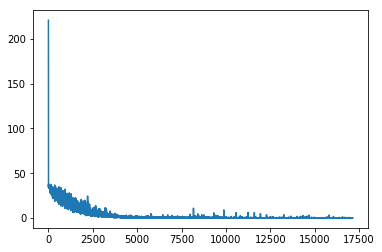

In [44]:
plt.plot(train_costs)
plt.plot(test_costs)
plt.show()

In [45]:
#y_test_df = np.array(y_test_predicted)
#y_test_index_df = np.array(y_test_index)
#y_test_df
err = error_rate(y_test, y_test_predicted)
err

0.21551020408163266

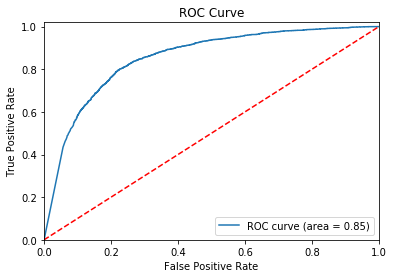

In [46]:
FPR, TPR, _ = roc_curve(y_test, y_test_predicted_prob)
AUC = auc(FPR, TPR)
plt.figure()
plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % AUC)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [51]:
print(train_costs[-1])

0.026158817
